# Exporting DeePTB Models to External Tools

DeePTB not only provides its own powerful training and analysis tools but also allows you to export your trained tight-binding models to popular external formats. This opens up compatibility with a vast ecosystem of post-processing tools.

In this tutorial, we will demonstrate:
1. Exporting a DeePTB model directly to a **PythTB** model object for interactive analysis.

## Prerequisites

Ideally, you should have `dptb` installed. For the PythTB section, you will need `pythtb` installed (`uv sync --extra pythtb` or `uv run pip install pythtb` or `pip install pythtb`).

In [203]:
import os
import torch
from dptb.nn import build_model
from dptb.data import AtomicData
from ase.io import read
from dptb.postprocess.interfaces import ToWannier90, ToPythTB
import matplotlib.pyplot as plt
import numpy as np
from dptb.postprocess.bandstructure.band import Band


In [42]:
# Define paths to example data (adjust if running elsewhere)
root_dir = os.path.abspath(".") 
model_path = os.path.join(root_dir, "models", "nnsk.ep20.pth")
struct_path = os.path.join(root_dir, "silicon.vasp")
model = build_model(model_path)
model.eval()

The model option atomic_radius in nnsk is not defined in input model_options, set to v1.


NNSK(
  (hamiltonian): SKHamiltonian()
)

## 1. Use DeePTB band plot to get the band structure of the model.

eig_solver is not set, using default 'torch'.


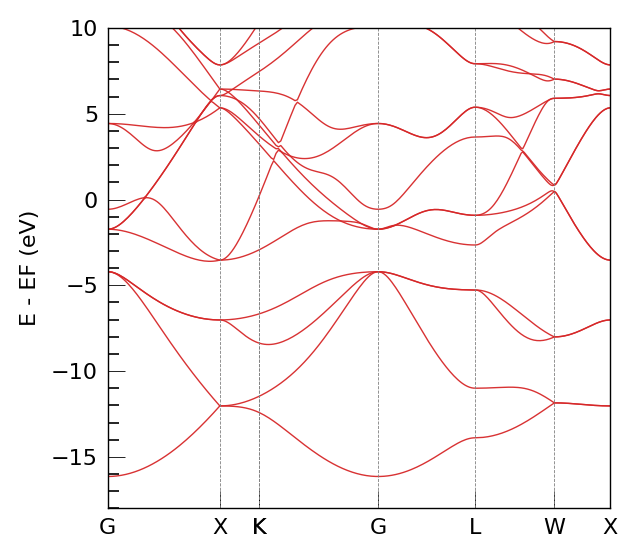

In [46]:
jdata={   
    "task_options": {
        "task": "band",
        "kline_type":"abacus",
        "kpath":[[0.0000000000,  0.0000000000,   0.0000000000,   50],   
                [0.5000000000,   0.0000000000,   0.5000000000,   50],               
                [0.6250000000,   0.2500000000,   0.6250000000,   1],    
                [0.3750000000,   0.3750000000,   0.7500000000,   50],     
                [0.0000000000,   0.0000000000,   0.0000000000,   50],    
                [0.5000000000,   0.5000000000,   0.5000000000,   50],                
                [0.5000000000,   0.2500000000,   0.7500000000,   50],               
                [0.5000000000,   0.0000000000,   0.5000000000,   1 ]
                ],
        "klabels":["G","X","X/U","K","G","L","W","X"],
        "nel_atom":{"Si":4},
        "E_fermi":-4.722,
        "emin":-18,
        "emax":10,
        "ref_band": "./data/kpath.0/eigenvalues.npy"
    }
}
kpath_kwargs = jdata["task_options"]
stru_data = "silicon.vasp"
bcal = Band(model=model, 
            use_gui=True, 
            device=model.device)
eigens = bcal.get_bands(data=stru_data, 
               kpath_kwargs=kpath_kwargs)
bcal.band_plot(ref_band = None,
               E_fermi = kpath_kwargs["E_fermi"],
               emin = kpath_kwargs["emin"],
               emax = kpath_kwargs["emax"])

## 2. Export to PythTB

PythTB is a lightweight tight-binding solver in Python. We can convert our DeePTB model directly into a `pythtb` model object.

Model converted to PythTB!
----- k_path report begin ----------
real-space lattice vectors
 [[0.    2.715 2.715]
 [2.715 0.    2.715]
 [2.715 2.715 0.   ]]
k-space metric tensor
 [[ 0.10175 -0.03392 -0.03392]
 [-0.03392  0.10175 -0.03392]
 [-0.03392 -0.03392  0.10175]]
internal coordinates of nodes
 [[0.    0.    0.   ]
 [0.5   0.    0.5  ]
 [0.625 0.25  0.625]
 [0.375 0.375 0.75 ]
 [0.    0.    0.   ]
 [0.5   0.5   0.5  ]
 [0.5   0.25  0.75 ]
 [0.5   0.    0.5  ]]
reciprocal-space lattice vectors
 [[-0.18416  0.18416  0.18416]
 [ 0.18416 -0.18416  0.18416]
 [ 0.18416  0.18416 -0.18416]]
cartesian coordinates of nodes
 [[0.00000e+00 0.00000e+00 0.00000e+00]
 [0.00000e+00 1.84162e-01 0.00000e+00]
 [4.60405e-02 1.84162e-01 4.60405e-02]
 [1.38122e-01 1.38122e-01 6.93889e-18]
 [0.00000e+00 0.00000e+00 0.00000e+00]
 [9.20810e-02 9.20810e-02 9.20810e-02]
 [9.20810e-02 1.84162e-01 6.93889e-18]
 [0.00000e+00 1.84162e-01 0.00000e+00]]
list of segments:
  length = 0.18416  from  [0. 0. 0.]  to  

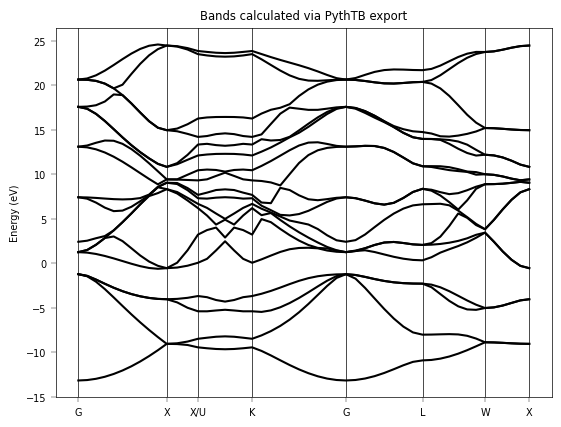

In [47]:
try:
    import pythtb
    
    # Initialize Converter
    pythtb_converter = ToPythTB(model, device="cpu")
    
    # Convert
    # providing e_fermi shifts the onsite energies
    my_tb_model = pythtb_converter.get_model(struct_path, e_fermi=-7.72)
    
    print("Model converted to PythTB!")
    print(my_tb_model)
    # Solve and Plot Bands
    path = [[0.0000000000,   0.0000000000,   0.0000000000],   
            [0.5000000000,   0.0000000000,   0.5000000000],               
            [0.6250000000,   0.2500000000,   0.6250000000],    
            [0.3750000000,   0.3750000000,   0.7500000000],     
            [0.0000000000,   0.0000000000,   0.0000000000],    
            [0.5000000000,   0.5000000000,   0.5000000000],                
            [0.5000000000,   0.2500000000,   0.7500000000],               
            [0.5000000000,   0.0000000000,   0.5000000000]
            ]

    labels = ["G","X","X/U","K","G","L","W","X"]
    
    (k_vec, k_dist, k_node) = my_tb_model.k_path(path, 50)
    evals = my_tb_model.solve_all(k_vec)
    
    fig, ax = plt.subplots()
    for band in evals:
        ax.plot(k_dist, band, color='k')
        
    for n in k_node:
        ax.axvline(n, linewidth=0.5, color='k')
    ax.set_xticks(k_node)
    ax.set_xticklabels(labels)
    ax.set_title("Bands calculated via PythTB export")
    ax.set_ylabel("Energy (eV)")
    plt.show()
    
except ImportError:
    print("PythTB not installed. Skipping this section.")

## 为了对比直接使用DeePTB内置的能带计算时采用的k点。

In [48]:
evals = my_tb_model.solve_all(eigens['klist'])

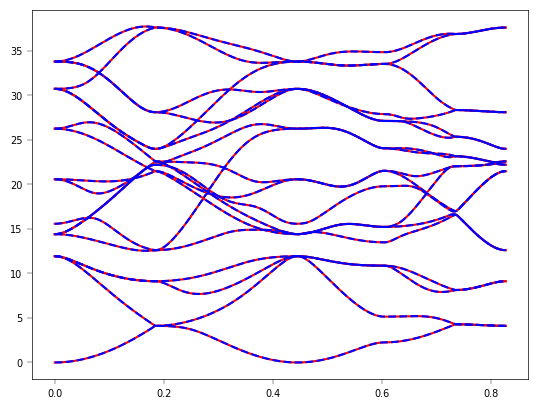

In [50]:
refeig = evals[:,:].T
plt.plot(eigens['xlist'],refeig - refeig.min() ,'r')
plt.plot(eigens['xlist'],eigens['eigenvalues']-eigens['eigenvalues'].min(),'b--')
plt.show()